In [1]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime

# Project Proposal:  NBA Prediction Module

Rui Ding rd2622

### Introduction

NBA today is no long only a basketball game of athletic talents and skills. To understand how well can a team perform and what kind of impact 
can an individual player bring about is a task that can not be achieved by pure verbal or conceptual qualification alone. Nowadays, teams utilize the
quantification power produced by data analysis and infer team performance predictions and player values, therefore helpinmg in their decision making processes.

In this project, my aim is to provide a simple system that uses the power of various ways of regression analysis, and based on their predictions infer
how well a team can be and many other important features to a game or to a team's full season status. Such predictions can be genralized to apply to assist in strategy
building processes involving trades, player ratings or even basketball lotteries.

    


### Regression Models and Key Regressors

To start with, I aim to get the data support from one of the most complete NBA database, basketball-reference.com.
The site contains various types of related stats ranging from player basic statistics, player advanced statistics, team ranking statistics to team advanced statistics.
The first simple model will be to analyzes the correlation between individual player’s statistics and their team’s performance, and develops a prediction model that can be used to forecast regular season results of NBA teams based on common player statistics.
One of the best ways to characterize a player's ability and contribution to his team is the advanced stat Player Efficientcy Ratio(PER) developed by former ESPN analyst John Hollinger.
There are many advantages to this simple metric which contains a whole lot of information, the details will be left in the full project description.
Among the most mportant factors for choosing this statistic to be a basis of analysis is that it is a simple evaluation of any individual player, and adjusts
for the pace of the games he played as well as the minutes played. This is a key feature because games today are so different from just a few years ago,
and strtegies from different teams vary a lot, therefore this adjustment keeps the metric fair as a rating of any individual player.

Using the PER values from the advanced data I get from basketball-reference.com, for seasonal prediction I run a simple regression for a team's averaged PER rating against its winning ratio
from the past season(for the current season 2016-2017, the database would be 2015-2016). And for per game prediction I will run
a linear regression taking the PER of home and guest teams against the winning margin of the hometeam. A game winner probability prediction will
model a logistic regression using the same input regressors and the variable being the binary indicator for whether the home team wins or not.
The key regressor averaged PER for a team is formulated as such :
    
AvgPER of $Team_i$ = Sum of (total minutes a player played for $Team_i$ * PER recorded for that player when playing for $Team_i$) 
/ Sum of (total minutes players played for $Team_i$)

### Seasonal Prediction

My goal is to check if this regression model predicts the seasonal status of each team for the 2016-2017 season well. As input one can enter the avgPER this season
calculated as above, and predict the winning ratio using the model coefficients. Moreover, we can adjust for higher accuracy based on real life intuitions, such as we can
leave out players who don't play much(benchwarmers), therefore their minutes don't count in the total contribution. The following code implements this process and we see a $R^2$
of 0.85 for the training dataset and a $R^2$ of 0.64 for the testing dataset. The data points are contributed by the 30 NBA teams and they are plotted below.
For the cell below, an example is shown using locally stored data files, while after the project finishes the part about online wrapping, then storage is no longer
needed.


0.850528089816
[[ 0.1514908]]
[-1.78164681]


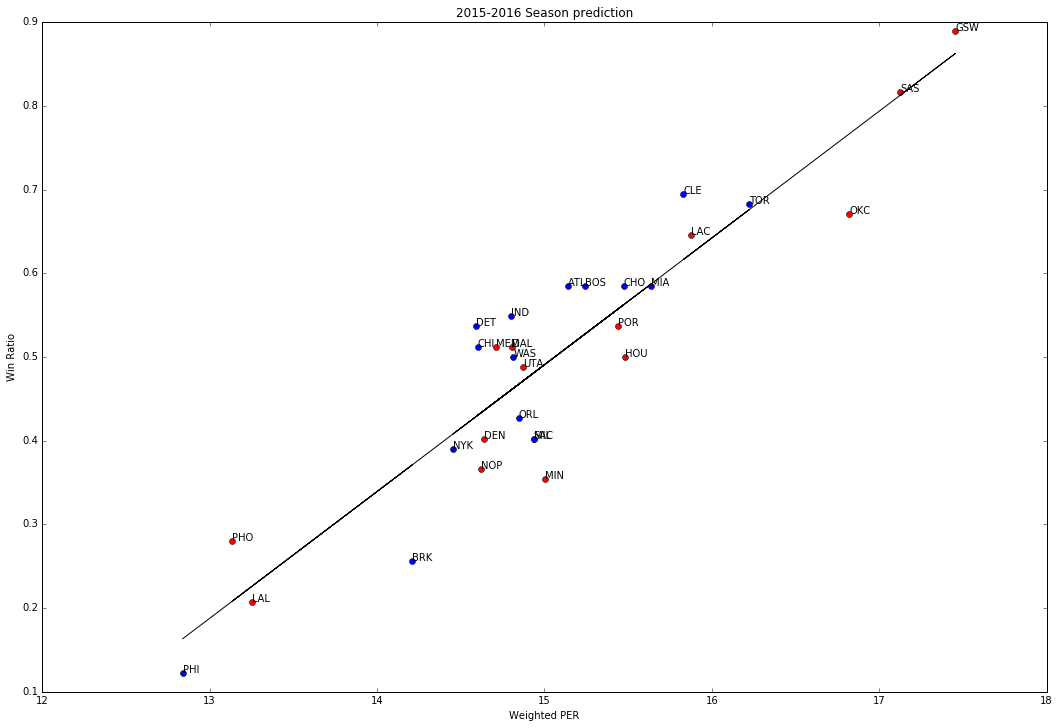

In [15]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Teams = ['SAS','GSW','OKC','CLE','TOR','LAC','ATL','BOS','CHO','UTA','IND','MIA','POR','DET','HOU','DAL','WAS','CHI','ORL','MEM','SAC','DEN','NYK','NOP','MIN','MIL','PHO','BRK','LAL','PHI']
Wins_train = []
Conf_train = []
TeamFull = []
with open('C:/Users/lhren/Desktop/nbaData/16team.csv', 'rb') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
     for row in spamreader:
         if row[1]!='Team':
             Wins_train.append(float(row[6]))
             Conf_train.append(int(row[2] == 'W'))
             TeamFull.append(row[1])
PERAvg_train = np.zeros(30)
GP_train = np.zeros(30)
Min_train = np.zeros(30)
with open('C:/Users/lhren/Desktop/nbaData/2015-2016.csv', 'rb') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
     
     for row in spamreader:
        if row[0]!='"Rk' and row[4]!='TOT':
            team = row[4]
            mins = row[6]
            gp = row[5]
            index = Teams.index(team)
            if float(mins)/float(gp) > 8.0:
                GP_train[index] += int(gp)
                Min_train[index] += int(mins)
                PERAvg_train[index] += float(row[7]) * int(mins)
PERAvg_train /= Min_train
PERAvg_train = np.array(PERAvg_train).reshape((30,1))
Wins_train = np.array(Wins_train).reshape((30,1))
Conf = np.array(Conf_train).reshape((30,1))
X = np.zeros((30,2))

from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(PERAvg_train, Wins_train)
print regr.score(PERAvg_train, Wins_train)
print regr.coef_
print regr.intercept_
fitted = regr.predict(PERAvg_train)
colors = ['b','r']
plt.figure(figsize=(18,12))

for i in range(30):
    plt.plot(PERAvg_train[i], Wins_train[i],str(colors[int(Conf[i])])+'o')
    plt.annotate(Teams[i], xy=(PERAvg_train[i],Wins_train[i]), xytext=(PERAvg_train[i], Wins_train[i]))

plt.plot(PERAvg_train, fitted, 'k')
plt.ylabel("Win Ratio")
plt.xlabel("Weighted PER")
plt.title("2015-2016 Season prediction")
plt.show()
##############################################


#### Data Wrapping and API Building 

As for the completion of this project in the sense of an API I plan to wrap the above models into an applicaiton that allows for user inputs as the queries to be made, and
the model outputs results based on the kind of queries made. This would require instant access to the database. For this purpose I used the BeautifulSoup
package and, for example using the code below for seasonal advanced stats, wraps that specific page of data from basketball-reference.com website tables into strig lists as the database, which can be done once given the
year of the season to be analyzed. The code is sensitive to the specifics of the kind of data to be acquired. Once we wrapped the advanced stats into 
lists of strings, we can then run the program from above with minor changes.

In [16]:
#regular season data wrapping
advanced_17 = 'http://www.basketball-reference.com/leagues/NBA_2017_advanced.html'

req = requests.get(advanced_17) 

text = BeautifulSoup(req.text, 'html.parser')
stats = text.find('div',{'id': 'all_advanced_stats'}) 

# find the schema 


In [17]:
cols = [i.get_text() for i in stats.thead.find_all('th')] 

# convert from unicode to string 
cols = [x.encode('UTF8') for x in cols] 

# get rows 
rows=[]
for i in stats.tbody.find_all('tr'):
    cols = [j.get_text() for j in i.find_all('td')] 
    
    row_i = [x.encode('UTF8') for x in cols]
    
    rows.append(row_i)

print rows[0]

['Alex Abrines', 'SG', '23', 'OKC', '68', '1055', '10.1', '.560', '.724', '.144', '1.9', '7.1', '4.5', '5.5', '1.7', '0.6', '8.3', '15.9', '', '1.2', '0.9', '2.1', '.095', '', '-0.3', '-2.2', '-2.5', '-0.1']


In [18]:
team_17 = 'http://www.basketball-reference.com/leagues/NBA_2017_ratings.html'
req = requests.get(team_17) 

text = BeautifulSoup(req.text, 'html.parser')
stats = text.find('div',{'id': 'all_ratings'}) 

In [19]:
cols = [i.get_text() for i in stats.thead.find_all('th')] 

# convert from unicode to string 
cols = [x.encode('UTF8') for x in cols] 
#print cols
# get rows 
teams=[]
for i in stats.tbody.find_all('tr'):
    cols = [j.get_text() for j in i.find_all('td')] 
    
    row_i = [x.encode('UTF8') for x in cols]
    
    teams.append(row_i)



From the generated rows ndarray we can easily modify the indices and reframe the data to fit the method used above.

0.642777458479


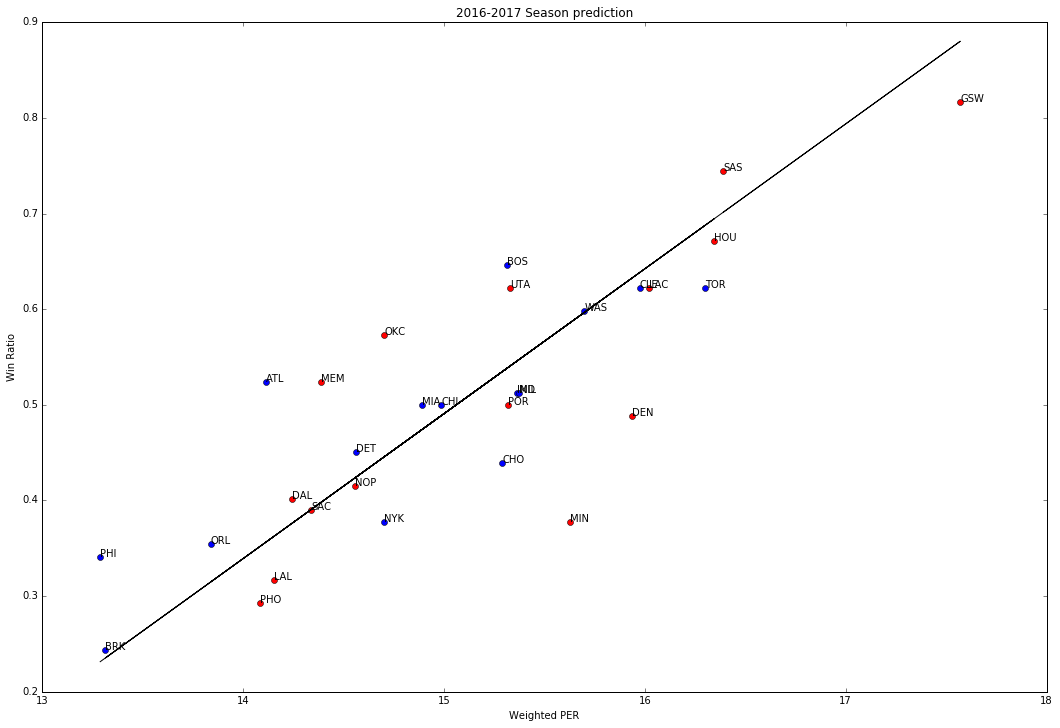

In [21]:
Wins = np.zeros(30)

for team in teams:
    
    index = TeamFull.index(team[0])
    Wins[index] = float(team[5])
            
PERAvg = np.zeros(30)
GP = np.zeros(30)
Min = np.zeros(30)

for row in rows:
    if len(row)==0:
        continue
    if row[3]!='TOT':
        team = row[3]
        mins = row[5]
        gp = row[4]
        index = Teams.index(team)
        if float(mins)/float(gp) > 8.0:
            GP[index] += int(gp)
            Min[index] += int(mins)
            PERAvg[index] += float(row[6]) * int(mins)
PERAvg /= Min
PERAvg = np.array(PERAvg).reshape((30,1))
Wins = np.array(Wins).reshape((30,1))


####
predicted = regr.predict(PERAvg)


####
print regr.score(PERAvg, Wins)
colors = ['b','r']
plt.figure(figsize=(18,12))

for i in range(30):
    plt.plot(PERAvg[i], Wins[i],str(colors[int(Conf[i])])+'o')
    plt.annotate(Teams[i], xy=(PERAvg[i],Wins[i]), xytext=(PERAvg[i], Wins[i]))
plt.plot(PERAvg, predicted, 'k')
plt.ylabel("Win Ratio")
plt.xlabel("Weighted PER")
plt.title("2016-2017 Season prediction")
plt.show()

### Game Prediction 

The game margin prediction and game winner prediction can be very useful for betting line decision and other practical uses. This is also a main concern
for the basketball fans. 

#### Perspective  (may not all be completed)

- Build an API to encompass some of the most desired prediction features of the NBA game, both for an analytical purpose and an pragmatic purpose.
- Base prediction of the current season's results on the previous season's data. Basic per game prediction results on the current season games  
based on the average rating of the two opposing teams and taking into account the homecourt advantage.
- Allow real-time inquiry and feedback.
- Testing data generated in real-time allowing update of information.

#### References 

To be added later.